In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Gerando dados de regressão
X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, 
                      noise=0.1, random_state=42)

# PASSO 1: Separação inicial (antes de qualquer processamento)
X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Dados de treino: {X_train_full.shape}")
print(f"Dados de teste final: {X_test_final.shape}")
print(f"Range do target: [{y.min():.2f}, {y.max():.2f}]")


Dados de treino: (800, 20)
Dados de teste final: (200, 20)
Range do target: [-699.25, 895.97]


In [2]:
from sklearn.metrics import make_scorer

def rmse_score(y_true, y_pred):
    """Calcula RMSE"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Criar scorer customizado para RMSE
rmse_scorer = make_scorer(rmse_score, greater_is_better=False)


In [47]:
# PASSO 2: Configuração da validação cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=4,min_samples_split=8, max_features=0.4)

# PASSO 3: Validação cruzada com métricas de regressão
cv_results = cross_validate(
    model, X_train_full, y_train_full,
    cv=cv,
    scoring={
        'r2': 'r2',
        'rmse': rmse_scorer,
        'mae': 'neg_mean_absolute_error'
    },
    return_train_score=True,
    n_jobs=-1
)

# Converter RMSE para valores positivos (vem negativo do scorer)
cv_results['train_rmse'] = -cv_results['train_rmse']
cv_results['test_rmse'] = -cv_results['test_rmse']
cv_results['train_mae'] = -cv_results['train_mae']
cv_results['test_mae'] = -cv_results['test_mae']

print("=== ANÁLISE DOS FOLDS (REGRESSÃO) ===")
for fold in range(5):
    # R² (maior é melhor)
    train_r2 = cv_results['train_r2'][fold]
    val_r2 = cv_results['test_r2'][fold]
    gap_r2 = train_r2 - val_r2
    
    # RMSE (menor é melhor)
    train_rmse = cv_results['train_rmse'][fold]
    val_rmse = cv_results['test_rmse'][fold]
    gap_rmse = val_rmse - train_rmse  # Overfitting = validação pior que treino
    
    print(f"Fold {fold+1}:")
    print(f"  R² - Treino: {train_r2:.4f}, Validação: {val_r2:.4f}, Gap: {gap_r2:.4f}")
    print(f"  RMSE - Treino: {train_rmse:.4f}, Validação: {val_rmse:.4f}, Gap: {gap_rmse:.4f}")
    print()



=== ANÁLISE DOS FOLDS (REGRESSÃO) ===
Fold 1:
  R² - Treino: 0.6304, Validação: 0.5102, Gap: 0.1202
  RMSE - Treino: 143.7873, Validação: 160.7082, Gap: 16.9209

Fold 2:
  R² - Treino: 0.6268, Validação: 0.5429, Gap: 0.0839
  RMSE - Treino: 142.8986, Validação: 163.6127, Gap: 20.7141

Fold 3:
  R² - Treino: 0.6500, Validação: 0.4495, Gap: 0.2005
  RMSE - Treino: 138.6579, Validação: 177.9742, Gap: 39.3163

Fold 4:
  R² - Treino: 0.6482, Validação: 0.4539, Gap: 0.1943
  RMSE - Treino: 140.5862, Validação: 169.1808, Gap: 28.5947

Fold 5:
  R² - Treino: 0.6439, Validação: 0.4690, Gap: 0.1749
  RMSE - Treino: 140.6766, Validação: 170.4486, Gap: 29.7720



In [48]:
print("=== ANÁLISE DE OVERFITTING (REGRESSÃO) ===")

# Análise R² (gap positivo alto indica overfitting)
r2_gaps = cv_results['train_r2'] - cv_results['test_r2']
rmse_gaps = cv_results['test_rmse'] - cv_results['train_rmse']

print("R² Analysis:")
print(f"  Gap médio (treino - validação): {r2_gaps.mean():.4f} ± {r2_gaps.std():.4f}")
print(f"  R² médio validação: {cv_results['test_r2'].mean():.4f} ± {cv_results['test_r2'].std():.4f}")

print("\nRMSE Analysis:")
print(f"  Gap médio (validação - treino): {rmse_gaps.mean():.4f} ± {rmse_gaps.std():.4f}")
print(f"  RMSE médio validação: {cv_results['test_rmse'].mean():.4f} ± {cv_results['test_rmse'].std():.4f}")

# Critérios para regressão
r2_overfitting = r2_gaps.mean() > 0.1  # Gap R² > 0.1
rmse_overfitting = rmse_gaps.mean() > np.std(y_train_full) * 0.1  # Gap RMSE > 10% do desvio do target

if r2_overfitting or rmse_overfitting:
    print("\n⚠️  ALERTA: Possível overfitting detectado!")
    print("   Considere:")
    print("   - Reduzir max_depth")
    print("   - Aumentar min_samples_split")
    print("   - Reduzir número de features")
else:
    print("\n✅ Gaps aceitáveis - modelo parece bem calibrado")


=== ANÁLISE DE OVERFITTING (REGRESSÃO) ===
R² Analysis:
  Gap médio (treino - validação): 0.1548 ± 0.0453
  R² médio validação: 0.4851 ± 0.0360

RMSE Analysis:
  Gap médio (validação - treino): 27.0636 ± 7.7846
  RMSE médio validação: 168.3849 ± 5.9758

⚠️  ALERTA: Possível overfitting detectado!
   Considere:
   - Reduzir max_depth
   - Aumentar min_samples_split
   - Reduzir número de features


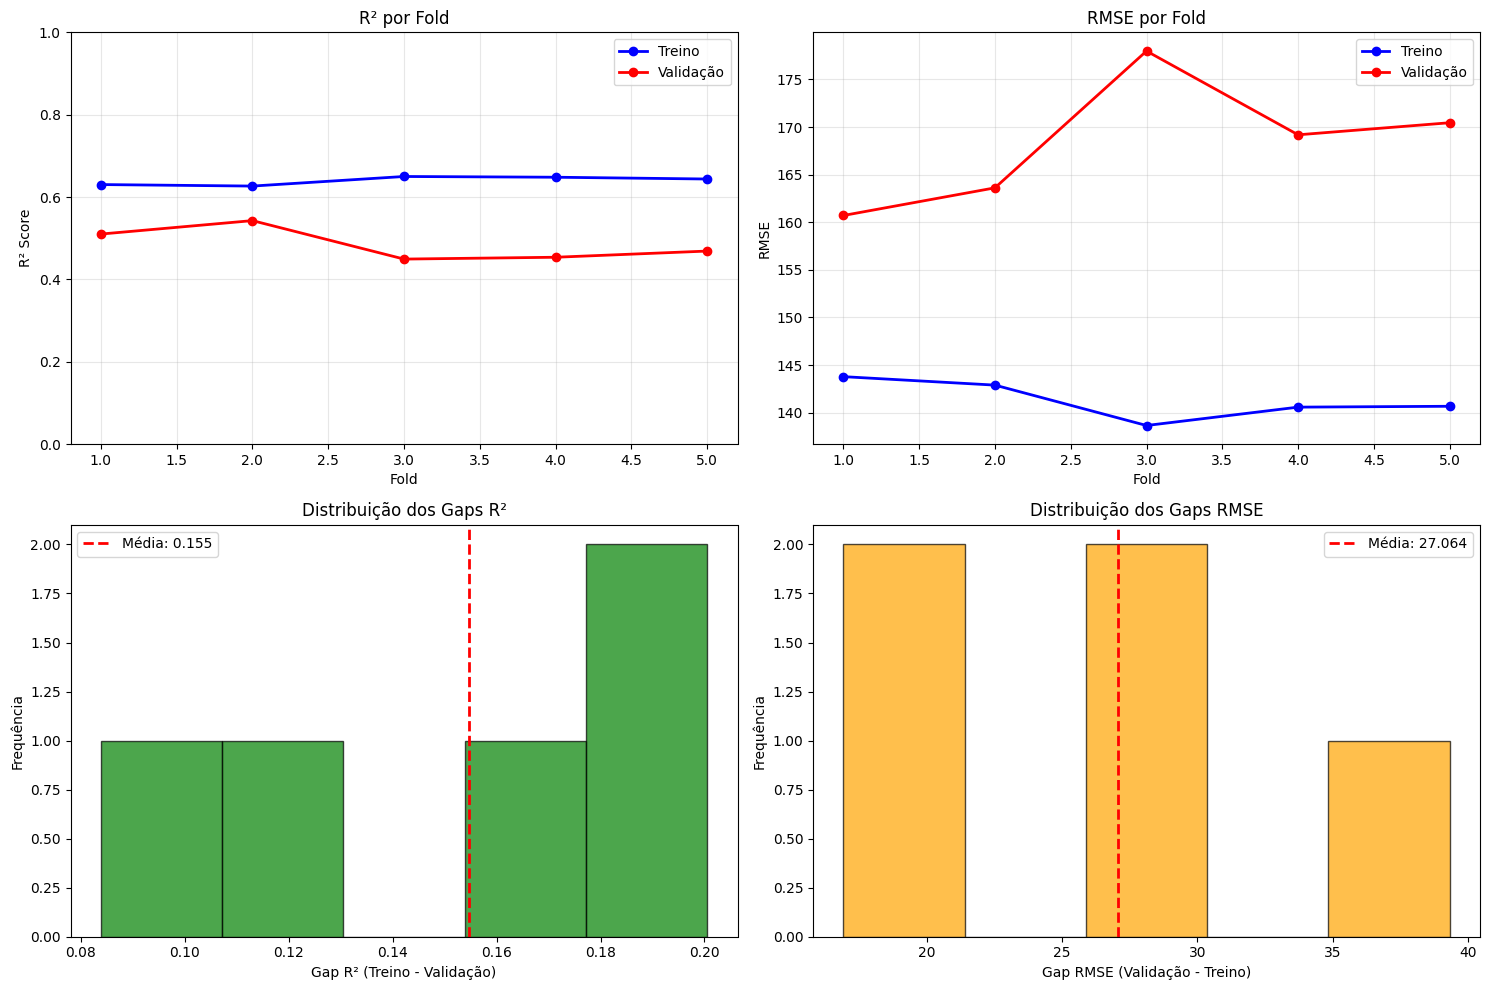

In [49]:
# Visualizações específicas para regressão
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

folds = range(1, 6)

# Gráfico 1: R² por fold
ax1.plot(folds, cv_results['train_r2'], 'o-', label='Treino', color='blue', linewidth=2)
ax1.plot(folds, cv_results['test_r2'], 'o-', label='Validação', color='red', linewidth=2)
ax1.set_xlabel('Fold')
ax1.set_ylabel('R² Score')
ax1.set_title('R² por Fold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Gráfico 2: RMSE por fold
ax2.plot(folds, cv_results['train_rmse'], 'o-', label='Treino', color='blue', linewidth=2)
ax2.plot(folds, cv_results['test_rmse'], 'o-', label='Validação', color='red', linewidth=2)
ax2.set_xlabel('Fold')
ax2.set_ylabel('RMSE')
ax2.set_title('RMSE por Fold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gráfico 3: Distribuição dos gaps R²
ax3.hist(r2_gaps, bins=5, alpha=0.7, color='green', edgecolor='black')
ax3.axvline(r2_gaps.mean(), color='red', linestyle='--', 
           label=f'Média: {r2_gaps.mean():.3f}', linewidth=2)
ax3.set_xlabel('Gap R² (Treino - Validação)')
ax3.set_ylabel('Frequência')
ax3.set_title('Distribuição dos Gaps R²')
ax3.legend()

# Gráfico 4: Distribuição dos gaps RMSE
ax4.hist(rmse_gaps, bins=5, alpha=0.7, color='orange', edgecolor='black')
ax4.axvline(rmse_gaps.mean(), color='red', linestyle='--', 
           label=f'Média: {rmse_gaps.mean():.3f}', linewidth=2)
ax4.set_xlabel('Gap RMSE (Validação - Treino)')
ax4.set_ylabel('Frequência')
ax4.set_title('Distribuição dos Gaps RMSE')
ax4.legend()

plt.tight_layout()
plt.show()



In [50]:
def analyze_regression_cv(cv_results, target_std):
    """
    Análise específica para resultados de validação cruzada em regressão
    
    Args:
        cv_results: Resultados do cross_validate
        target_std: Desvio padrão do target para contextualizar RMSE
    """
    print("=== ANÁLISE DETALHADA REGRESSÃO ===")
    
    # Métricas principais
    r2_train = cv_results['train_r2']
    r2_val = cv_results['test_r2']
    rmse_train = cv_results['train_rmse']
    rmse_val = cv_results['test_rmse']
    
    # Gaps
    r2_gaps = r2_train - r2_val
    rmse_gaps = rmse_val - rmse_train
    
    print("1. PERFORMANCE GERAL:")
    print(f"   R² médio: {r2_val.mean():.4f} ± {r2_val.std():.4f}")
    print(f"   RMSE médio: {rmse_val.mean():.4f} ± {rmse_val.std():.4f}")
    print(f"   RMSE como % do std target: {(rmse_val.mean()/target_std)*100:.1f}%")
    
    print("\n2. ESTABILIDADE:")
    cv_r2 = r2_val.std() / r2_val.mean() if r2_val.mean() > 0 else float('inf')
    cv_rmse = rmse_val.std() / rmse_val.mean()
    print(f"   Coef. Variação R²: {cv_r2:.4f}")
    print(f"   Coef. Variação RMSE: {cv_rmse:.4f}")
    
    print("\n3. OVERFITTING:")
    print(f"   Gap R² médio: {r2_gaps.mean():.4f}")
    print(f"   Gap RMSE médio: {rmse_gaps.mean():.4f}")
    
    # Interpretação
    print("\n4. INTERPRETAÇÃO:")
    if r2_val.mean() > 0.8:
        print("   ✅ R² excelente (>0.8)")
    elif r2_val.mean() > 0.6:
        print("   ✅ R² bom (0.6-0.8)")
    elif r2_val.mean() > 0.4:
        print("   ⚠️  R² moderado (0.4-0.6)")
    else:
        print("   ❌ R² baixo (<0.4)")
    
    if rmse_val.mean() / target_std < 0.1:
        print("   ✅ RMSE excelente (<10% std)")
    elif rmse_val.mean() / target_std < 0.2:
        print("   ✅ RMSE bom (10-20% std)")
    else:
        print("   ⚠️  RMSE alto (>20% std)")
    
    return {
        'r2_mean': r2_val.mean(),
        'r2_std': r2_val.std(),
        'rmse_mean': rmse_val.mean(),
        'rmse_std': rmse_val.std(),
        'r2_gap': r2_gaps.mean(),
        'rmse_gap': rmse_gaps.mean()
    }

# Aplicar análise
results_summary = analyze_regression_cv(cv_results, np.std(y_train_full))


=== ANÁLISE DETALHADA REGRESSÃO ===
1. PERFORMANCE GERAL:
   R² médio: 0.4851 ± 0.0360
   RMSE médio: 168.3849 ± 5.9758
   RMSE como % do std target: 71.5%

2. ESTABILIDADE:
   Coef. Variação R²: 0.0741
   Coef. Variação RMSE: 0.0355

3. OVERFITTING:
   Gap R² médio: 0.1548
   Gap RMSE médio: 27.0636

4. INTERPRETAÇÃO:
   ⚠️  R² moderado (0.4-0.6)
   ⚠️  RMSE alto (>20% std)


In [51]:
def should_revise_regression_hyperparameters(cv_results, target_std, 
                                           r2_gap_threshold=0.15, 
                                           rmse_gap_threshold=0.2,
                                           min_r2=0.5):
    """
    Determina se deve revisar hiperparâmetros para modelos de regressão
    """
    r2_gaps = cv_results['train_r2'] - cv_results['test_r2']
    rmse_gaps = cv_results['test_rmse'] - cv_results['train_rmse']
    
    r2_mean = cv_results['test_r2'].mean()
    rmse_relative = cv_results['test_rmse'].mean() / target_std
    
    print("=== CRITÉRIOS DE DECISÃO (REGRESSÃO) ===")
    
    # Critérios
    high_r2_gap = r2_gaps.mean() > r2_gap_threshold
    high_rmse_gap = (rmse_gaps.mean() / target_std) > rmse_gap_threshold
    low_r2 = r2_mean < min_r2
    high_variance = cv_results['test_r2'].std() > 0.1
    
    print(f"Gap R² médio: {r2_gaps.mean():.4f} (limite: {r2_gap_threshold})")
    print(f"Gap RMSE relativo: {rmse_gaps.mean()/target_std:.4f} (limite: {rmse_gap_threshold})")
    print(f"R² médio: {r2_mean:.4f} (mínimo: {min_r2})")
    print(f"Std R²: {cv_results['test_r2'].std():.4f} (limite: 0.1)")
    
    should_revise = high_r2_gap or high_rmse_gap or low_r2 or high_variance
    
    if should_revise:
        print("\n❌ REVISAR HIPERPARÂMETROS:")
        if high_r2_gap: print("   - Gap R² muito alto (possível overfitting)")
        if high_rmse_gap: print("   - Gap RMSE muito alto (possível overfitting)")
        if low_r2: print("   - R² muito baixo (underfitting)")
        if high_variance: print("   - Alta variância entre folds")
        
        print("\n   SUGESTÕES:")
        print("   - Ajustar regularização (alpha para Ridge/Lasso)")
        print("   - Modificar complexidade do modelo (max_depth, min_samples_split)")
        print("   - Feature engineering ou seleção")
        print("   - Verificar outliers")
        print("   - Considerar ensemble methods")
    else:
        print("\n✅ CONTINUAR: Métricas dentro do esperado")
        print("   Modelo parece bem calibrado")
    
    return should_revise

# Aplicar critérios de decisão
should_revise = should_revise_regression_hyperparameters(
    cv_results, np.std(y_train_full)
)


=== CRITÉRIOS DE DECISÃO (REGRESSÃO) ===
Gap R² médio: 0.1548 (limite: 0.15)
Gap RMSE relativo: 0.1149 (limite: 0.2)
R² médio: 0.4851 (mínimo: 0.5)
Std R²: 0.0360 (limite: 0.1)

❌ REVISAR HIPERPARÂMETROS:
   - Gap R² muito alto (possível overfitting)
   - R² muito baixo (underfitting)

   SUGESTÕES:
   - Ajustar regularização (alpha para Ridge/Lasso)
   - Modificar complexidade do modelo (max_depth, min_samples_split)
   - Feature engineering ou seleção
   - Verificar outliers
   - Considerar ensemble methods


In [52]:
print("\n" + "="*50)
print("=== TESTE FINAL (REGRESSÃO) ===")

# Treinar modelo final com todos os dados de treino
final_model = RandomForestRegressor(n_estimators=100, random_state=42)
final_model.fit(X_train_full, y_train_full)

# Predições no conjunto de teste
final_predictions = final_model.predict(X_test_final)

# Métricas finais
final_r2 = r2_score(y_test_final, final_predictions)
final_rmse = rmse_score(y_test_final, final_predictions)
final_mae = np.mean(np.abs(y_test_final - final_predictions))

# Comparar com CV
cv_r2_mean = cv_results['test_r2'].mean()
cv_rmse_mean = cv_results['test_rmse'].mean()

print(f"RESULTADOS FINAIS:")
print(f"R² teste final: {final_r2:.4f}")
print(f"R² médio (CV): {cv_r2_mean:.4f}")
print(f"Diferença R²: {abs(final_r2 - cv_r2_mean):.4f}")
print()
print(f"RMSE teste final: {final_rmse:.4f}")
print(f"RMSE médio (CV): {cv_rmse_mean:.4f}")
print(f"Diferença RMSE: {abs(final_rmse - cv_rmse_mean):.4f}")
print()
print(f"MAE teste final: {final_mae:.4f}")

# Análise da consistência
r2_diff = abs(final_r2 - cv_r2_mean)
rmse_diff = abs(final_rmse - cv_rmse_mean)

print("\nCONSISTÊNCIA CV vs TESTE FINAL:")
if r2_diff < 0.05 and rmse_diff < (np.std(y_test_final) * 0.1):
    print("✅ Resultados consistentes entre CV e teste final")
    print("   O modelo generalizou bem para dados não vistos")
else:
    print("⚠️  ALERTA: Inconsistência entre CV e teste final!")
    if r2_diff > 0.05:
        print(f"   - Diferença R² alta: {r2_diff:.4f}")
    if rmse_diff > (np.std(y_test_final) * 0.1):
        print(f"   - Diferença RMSE alta: {rmse_diff:.4f}")
    print("   Possíveis causas:")
    print("   - Data leakage")
    print("   - Distribuição diferente entre treino e teste")
    print("   - Overfitting não detectado pelo CV")



=== TESTE FINAL (REGRESSÃO) ===
RESULTADOS FINAIS:
R² teste final: 0.6866
R² médio (CV): 0.4851
Diferença R²: 0.2015

RMSE teste final: 126.3539
RMSE médio (CV): 168.3849
Diferença RMSE: 42.0310

MAE teste final: 101.3403

CONSISTÊNCIA CV vs TESTE FINAL:
⚠️  ALERTA: Inconsistência entre CV e teste final!
   - Diferença R² alta: 0.2015
   - Diferença RMSE alta: 42.0310
   Possíveis causas:
   - Data leakage
   - Distribuição diferente entre treino e teste
   - Overfitting não detectado pelo CV
